In [45]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [46]:
from models.world_dit import WorldDiT

model = WorldDiT().to(device)
model.load_state_dict(
    torch.load("checkpoints/world_filmcond_pre_20251129_203128/model_2780.pth")
)

<All keys matched successfully>

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 830.70it/s]

[8341] Action: 0, up


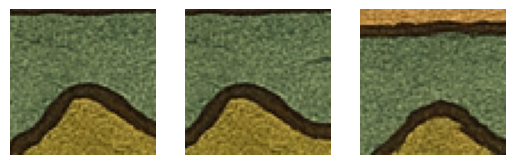

In [47]:
from train.world import world_ddim_sample
from dataset import WorldDataset, SelectSampleDataset
from train.diffusion import get_noise_schedule

# import random

torch.manual_seed(42)

T = 400
ddim_steps = 100

noise_schedule = get_noise_schedule(T, device=device)
dataset = WorldDataset("data/world_map.png")
dataset = SelectSampleDataset(dataset, num_samples=16)


# only show the final step
steps_to_show = [0]

xt = torch.randn(1, 3, 64, 64).to(device)

# idx = random.randint(0, len(dataset))
idx = 8341
start, action, end = dataset[idx]
start = start.to(device).unsqueeze(0)
action = torch.tensor(0).to(device).unsqueeze(0)

snapshots = world_ddim_sample(
    xt,
    model,
    start,
    action,
    noise_schedule,
    ddim_steps,
    steps_to_show,
)

fig, axes = plt.subplots(1, 3)
# dont show axes
for ax in axes.flat:
    ax.axis("off")

start = start.squeeze(0)
action_str = (
    "up"
    if action.item() == 0
    else "down"
    if action.item() == 1
    else "left"
    if action.item() == 2
    else "right"
)
print(f"[{idx}] Action: {action.item()}, {action_str}")
axes[0].imshow(start.permute(1, 2, 0).cpu().numpy())
axes[1].imshow(end.permute(1, 2, 0).cpu().numpy())
axes[2].imshow(snapshots[0].permute(1, 2, 0).cpu().numpy())

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 792.22it/s]

[5567] Action: 1, down


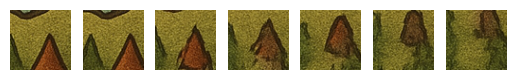

In [ ]:
from train.world import world_ddim_sample
from dataset import WorldDataset, SelectSampleDataset
from train.diffusion import get_noise_schedule

import random

torch.manual_seed(42)

T = 400
ddim_steps = 100

noise_schedule = get_noise_schedule(T, device=device)
dataset = WorldDataset("data/world_map.png")
dataset = SelectSampleDataset(dataset, num_samples=16)


# only show the final step
steps_to_show = [0]


idx = random.randint(0, len(dataset))
idx = 8341
# idx = 5567
start, action, end = dataset[idx]
start = start.to(device).unsqueeze(0)
action = torch.tensor(1).to(device).unsqueeze(0)

rollout_steps = 5

rollout_imgs = []
prev = start
for step in range(rollout_steps):
    xt = torch.randn(1, 3, 64, 64).to(device)
    snapshots = world_ddim_sample(
        xt,
        model,
        prev,
        action,
        noise_schedule,
        ddim_steps,
        steps_to_show,
    )
    rollout_imgs.append(snapshots[0])
    prev = snapshots[0].unsqueeze(0)
    prev = prev * 255

fig, axes = plt.subplots(1, rollout_steps + 2)
# dont show axes
for ax in axes.flat:
    ax.axis("off")

start = start.squeeze(0)
action_str = (
    "up"
    if action.item() == 0
    else "down"
    if action.item() == 1
    else "left"
    if action.item() == 2
    else "right"
)
print(f"[{idx}] Action: {action.item()}, {action_str}")
axes[0].imshow(start.permute(1, 2, 0).cpu().numpy())
axes[1].imshow(end.permute(1, 2, 0).cpu().numpy())
for i in range(rollout_steps):
    axes[i + 2].imshow(rollout_imgs[i].permute(1, 2, 0).cpu().numpy())